In [2]:
import glob
import tqdm
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from sklearn.model_selection import train_test_split
import random
import shutil
import os

In [3]:
# Using Apple Silicon Mac
print(torch.backends.mps.is_available()) 

True


In [4]:
all_imgs = glob.glob('/Users/ramalakshmi/Documents/xray_classification/Osteoporosis Knee X-ray/*/*.JPEG')
all_imgs.extend(glob.glob('/Users/ramalakshmi/Documents/xray_classification/Osteoporosis Knee X-ray/*/*.jpg'))
len(all_imgs)

239

### SAM mask sample

In [13]:
sam_checkpoint = "/Users/ramalakshmi/Documents/xray_classification/sam_vit_b_01ec64.pth"
model_type = "vit_b"

if torch.backends.mps.is_available():  
    device = "mps"     # Apple Silicon GPU
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [58]:
def generate_sam_mask(image_path, bboxes):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    predictor.set_image(image_rgb)

    masks = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        bw, bh = x2 - x1, y2 - y1

        # Five points: 1 top-center, 2 bottom-left/right, + top & bottom borders
        point_coords = np.array([
            [x1 + bw // 2, y1 + int(bh * 0.25)],         # top-center (inside bbox)
            [x1 + bw // 2 - bw // 6, y1 + int(bh * 0.75)],  # bottom-left of center
            [x1 + bw // 2 + bw // 6, y1 + int(bh * 0.75)],  # bottom-right of center
            [x1 + bw // 2, y1 + 3],                      # near top border (few px inside)
            [x1 + bw // 2, y2 - 3],                      # near bottom border (few px inside)
        ])
        point_labels = np.array([1] * len(point_coords))  # all positive

        input_box = np.array(bbox)

        mask, _, _ = predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            box=input_box,
            multimask_output=False,
        )
        masks.append(mask[0])
    return masks, image_rgb

In [37]:
def yolo_to_xyxy(xc, yc, w, h, img_w, img_h):
    x1 = int((xc - w/2) * img_w)
    y1 = int((yc - h/2) * img_h)
    x2 = int((xc + w/2) * img_w)
    y2 = int((yc + h/2) * img_h)
    return [x1, y1, x2, y2]

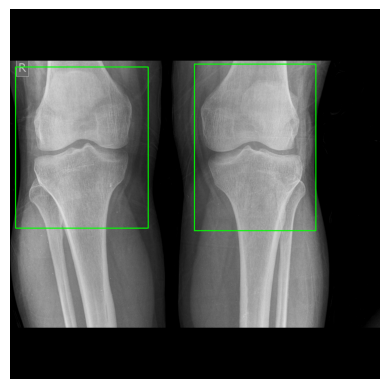

In [38]:
image_path = "/Users/ramalakshmi/Documents/xray_classification/Osteoporosis Knee X-ray/normal/N1.JPEG"
img = cv2.imread(image_path)
img_h, img_w = img.shape[:2]

with open('/Users/ramalakshmi/Documents/xray_classification/Osteoporosis Knee X-ray/normal_annotations/labels/train/N1.txt', 'r') as f:
    lines = f.readlines()

bboxes = []
for line in lines:
    parts = line.strip().split()
    if len(parts) == 5:
        x1, y1, x2, y2 = map(float, parts[1:])
        denorm_box = yolo_to_xyxy(x1, y1, x2, y2, img_w, img_h)
        bboxes.append(denorm_box)

# plot the bboxes on the image
for bbox in bboxes:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

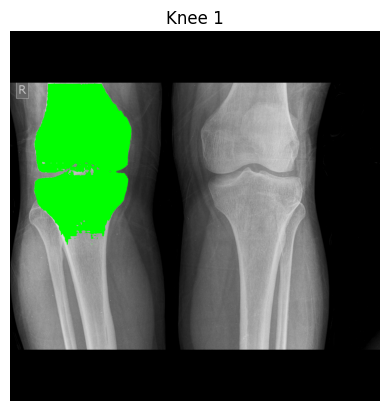

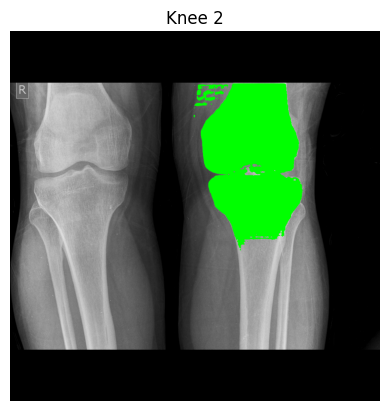

In [39]:
masks, img = generate_sam_mask(image_path, bboxes)

for i, mask in enumerate(masks):
    overlay = img.copy()
    overlay[mask] = (0, 255, 0)
    plt.imshow(overlay)
    plt.title(f"Knee {i+1}")
    plt.axis("off")
    plt.show()

### Generate SAM masks for all imgs and form a classifier dataset

In [61]:
# Define dataset paths and classes
base_input_dir = "/Users/ramalakshmi/Documents/xray_classification/Osteoporosis Knee X-ray"
base_output_dir = "/Users/ramalakshmi/Documents/xray_classification/classifier_dataset"

classes = ["normal", "osteopenia", "osteoporosis"]

# Split ratio
train_ratio = 0.8

for cls in classes:
    input_dir = os.path.join(base_input_dir, cls)

    # Collect all images in this class
    all_imgs = glob.glob(os.path.join(input_dir, "*.JPEG"))
    all_imgs.extend(glob.glob(os.path.join(input_dir, "*.jpg")))
    print(f"[{cls}] Found {len(all_imgs)} images.")

    # Train/val split
    train_imgs, val_imgs = train_test_split(all_imgs, train_size=train_ratio, random_state=42)

    splits = {"train": train_imgs, "val": val_imgs}

    for split_name, split_imgs in splits.items():
        output_dir = os.path.join(base_output_dir, split_name, cls)
        os.makedirs(output_dir, exist_ok=True)

        for image_path in tqdm.tqdm(split_imgs, desc=f"{cls} - {split_name}"):
            img = cv2.imread(image_path)
            if img is None:
                print(f"Failed to read {image_path}, skipping.")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_h, img_w = img.shape[:2]

            # Derive annotation path
            label_path = image_path.replace(
                f"Osteoporosis Knee X-ray/{cls}",
                f"Osteoporosis Knee X-ray/{cls}_annotations/labels/train"
            ).replace(".JPEG", ".txt").replace(".jpg", ".txt")

            if not os.path.exists(label_path):
                print(f"Label file not found for {image_path}, skipping.")
                continue

            # Load annotations
            with open(label_path, 'r') as f:
                lines = f.readlines()

            bboxes = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    x1, y1, x2, y2 = map(float, parts[1:])
                    denorm_box = yolo_to_xyxy(x1, y1, x2, y2, img_w, img_h)
                    bboxes.append(denorm_box)

            if not bboxes:
                print(f"No bounding boxes found in {label_path}, skipping.")
                continue

            # Generate SAM masks
            masks, img_rgb = generate_sam_mask(image_path, bboxes)

            base_name = os.path.basename(image_path).rsplit('.', 1)[0]

            for idx, (mask, bbox) in enumerate(zip(masks, bboxes)):
                x1, y1, x2, y2 = map(int, bbox)

                # Crop region from mask + image
                mask_crop = mask[y1:y2, x1:x2]
                img_crop = img_rgb[y1:y2, x1:x2]

                # Grey background for cropped region
                grey_value = 128
                masked_crop = np.full_like(img_crop, grey_value)
                masked_crop[mask_crop > 0] = img_crop[mask_crop > 0]

                # Save cropped masked image
                masked_img_save_path = os.path.join(output_dir, f"{base_name}_{idx+1}.png")
                cv2.imwrite(masked_img_save_path, cv2.cvtColor(masked_crop, cv2.COLOR_RGB2BGR))

        print(f"[{cls}] {split_name} processing complete. Crops saved to {output_dir}")


[normal] Found 36 images.


normal - train: 100%|██████████| 28/28 [00:30<00:00,  1.09s/it]


[normal] train processing complete. Crops saved to /Users/ramalakshmi/Documents/xray_classification/classifier_dataset/train/normal


normal - val: 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


[normal] val processing complete. Crops saved to /Users/ramalakshmi/Documents/xray_classification/classifier_dataset/val/normal
[osteopenia] Found 154 images.


osteopenia - train: 100%|██████████| 123/123 [02:08<00:00,  1.05s/it]


[osteopenia] train processing complete. Crops saved to /Users/ramalakshmi/Documents/xray_classification/classifier_dataset/train/osteopenia


osteopenia - val: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


[osteopenia] val processing complete. Crops saved to /Users/ramalakshmi/Documents/xray_classification/classifier_dataset/val/osteopenia
[osteoporosis] Found 49 images.


osteoporosis - train: 100%|██████████| 39/39 [00:40<00:00,  1.05s/it]


[osteoporosis] train processing complete. Crops saved to /Users/ramalakshmi/Documents/xray_classification/classifier_dataset/train/osteoporosis


osteoporosis - val: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

[osteoporosis] val processing complete. Crops saved to /Users/ramalakshmi/Documents/xray_classification/classifier_dataset/val/osteoporosis


### Generate segmentation dataset for RPN training

In [8]:
def generate_sam_mask(image_path, bboxes, predictor):
    image = image_path
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    predictor.set_image(image_rgb)

    masks = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        bw, bh = x2 - x1, y2 - y1

        # Five points: 1 top-center, 2 bottom-left/right, + top & bottom borders
        point_coords = np.array([
            [x1 + bw // 2, y1 + int(bh * 0.25)],         # top-center (inside bbox)
            [x1 + bw // 2 - bw // 6, y1 + int(bh * 0.75)],  # bottom-left of center
            [x1 + bw // 2 + bw // 6, y1 + int(bh * 0.75)],  # bottom-right of center
            [x1 + bw // 2, y1 + 3],                      # near top border (few px inside)
            [x1 + bw // 2, y2 - 3],                      # near bottom border (few px inside)
        ])
        point_labels = np.array([1] * len(point_coords))  # all positive

        input_box = np.array(bbox)

        mask, _, _ = predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            box=input_box,
            multimask_output=False,
        )
        masks.append(mask[0])
    return masks, image_rgb

In [9]:
def mask_to_polygons(mask, epsilon=0.01):
    """
    Convert a binary mask to polygon points.
    """
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        # Approximate contour to reduce number of points
        approx = cv2.approxPolyDP(contour, epsilon * cv2.arcLength(contour, True), True)
        polygons.append(approx.reshape(-1, 2))
    return polygons

In [10]:
def save_yolo_segmentation(label_path, polygons, class_id, img_w, img_h):
    """
    Save polygons in YOLOv8 segmentation format.
    """
    with open(label_path, "w") as f:
        for poly in polygons:
            norm_poly = []
            for x, y in poly:
                nx, ny = x / img_w, y / img_h
                norm_poly.extend([nx, ny])
            f.write(f"{class_id} " + " ".join(map(str, norm_poly)) + "\n")

In [11]:
base_dir = "/Users/ramalakshmi/Documents/xray_classification/Osteoporosis Knee X-ray"
output_base = "/Users/ramalakshmi/Documents/xray_classification/yolo_seg"

os.makedirs(os.path.join(output_base, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(output_base, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(output_base, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(output_base, "val", "labels"), exist_ok=True)

classes = ["normal", "osteopenia", "osteoporosis"]

In [14]:
for cls in classes:
    class_id = 0
    train_ratio = 0.8

    input_images = glob.glob(os.path.join(base_dir, cls, "*.JPEG"))
    input_images.extend(glob.glob(os.path.join(base_dir, cls, "*.jpg")))

    print(f"[{cls}] Found {len(input_images)} images")
    random.shuffle(input_images)

    # Train/val split
    split_idx = int(len(input_images) * train_ratio)
    train_imgs = input_images[:split_idx]
    val_imgs = input_images[split_idx:]

    for split, img_list in tqdm.tqdm(zip(["train", "val"], [train_imgs, val_imgs])):
        for image_path in tqdm.tqdm(img_list, desc=f"{cls}-{split}"):
            img = cv2.imread(image_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_h, img_w = img.shape[:2]

            base_name = os.path.splitext(os.path.basename(image_path))[0]
            label_in = image_path.replace(
                f"Osteoporosis Knee X-ray/{cls}",
                f"Osteoporosis Knee X-ray/{cls}_annotations/labels/train"
            ).rsplit(".", 1)[0] + ".txt"

            if not os.path.exists(label_in):
                continue

            # Load YOLO bboxes
            bboxes = []
            with open(label_in, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, cx, cy, w, h = map(float, parts)
                        x1 = int((cx - w / 2) * img_w)
                        y1 = int((cy - h / 2) * img_h)
                        x2 = int((cx + w / 2) * img_w)
                        y2 = int((cy + h / 2) * img_h)
                        bboxes.append([x1, y1, x2, y2])

            if not bboxes:
                continue

            polygons_all = []
            masks, _ = generate_sam_mask(img_rgb, bboxes, predictor)

            for bbox, mask in zip(bboxes, masks):
                polygons = mask_to_polygons(mask)
                if len(polygons) > 0:
                    poly = max(polygons, key=lambda p: cv2.contourArea(p.reshape(-1, 1, 2)))
                    polygons_all.append((class_id, poly))

            if not polygons_all:
                continue

            # Save label
            label_out = os.path.join(output_base, split, "labels", base_name + ".txt")
            with open(label_out, "w") as f:
                for cls_id, poly in polygons_all:
                    norm_poly = []
                    for x, y in poly.reshape(-1, 2):
                        norm_poly.append(x / img_w)
                        norm_poly.append(y / img_h)

                    line = str(cls_id) + " " + " ".join([f"{v:.6f}" for v in norm_poly])
                    f.write(line + "\n")

            # Save image
            img_out = os.path.join(output_base, split, "images", os.path.basename(image_path))
            cv2.imwrite(img_out, img)

print("✅ YOLO segmentation dataset generated with train/val split")

[normal] Found 36 images


normal-val: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]
2it [00:43, 21.52s/it]


[osteopenia] Found 154 images


osteopenia-val: 100%|██████████| 31/31 [00:31<00:00,  1.01s/it]
2it [02:36, 78.04s/it] 


[osteoporosis] Found 49 images


osteoporosis-val: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
2it [00:49, 24.82s/it]

✅ YOLO segmentation dataset generated with train/val split


In [17]:
import yaml, os
from glob import glob

# Load dataset yaml
with open("datasets.yaml") as f:
    data = yaml.safe_load(f)

# Count images and labels
train_images = glob(os.path.join(data["path"], data["train"], "*.jpg"))
val_images   = glob(os.path.join(data["path"], data["val"], "*.jpg"))

print("Train images:", len(train_images))
print("Val images:", len(val_images))

# Check if corresponding .txt labels exist
for img_path in train_images:
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
    if not os.path.exists(label_path):
        print("Missing label for:", img_path)
    # print(img_path, "->", os.path.exists(label_path))

Train images: 138
Val images: 38
